# Introduction

In this notebook, we want to analyze eviction data in nyc using DBSCAN and kmeans clustering algos and continue with the previous notebook and visualize in Folium.

In [2]:
# !pip install geopandas folium matplotlib seaborn scipy
# !pip install esda
# !pip install splot
# !pip install geopandas contextily
# # for google colab, had to reinstall some pacakges.

In [ ]:
# !pip install geopandas folium matplotlib seaborn scipy esda splot

In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import datetime as dt
import scipy

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from shapely.geometry import Point

# visualization
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns
import folium
from folium.plugins import HeatMap
from folium import Marker
from folium.plugins import MarkerCluster
import plotly.express as px
import plotly.io as pio
import contextily as ctx

# spatial statistics
from esda.moran import Moran
from esda.getisord import G_Local
from libpysal.weights import Queen, Rook

# system and utility
import warnings
import os
import io
from IPython.display import IFrame
from google.colab import files

from libpysal.weights import Queen, Rook
from esda.moran import Moran
import matplotlib.pyplot as plt
from splot.esda import moran_scatterplot

# suppress warnings
warnings.filterwarnings('ignore')

# inline
%matplotlib inline

# Part 1 Get the Eviction data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# data source:
file_path = '/content/drive/My Drive/X999/evictions_cleaned.csv'

In [6]:
evictions_cleaned_raw = pd.read_csv(file_path)

In [7]:
evictions_cleaned = evictions_cleaned_raw.copy()

In [8]:
evictions_cleaned.head(2)

court_index_number  docket_number eviction_address  \
0         *313639/23           5202  710 61ST STREET   
1         *324973/22           5308  462 60TH STREET   

  eviction_apartment_number executed_date   borough  eviction_postcode  \
0                 2ND FLOOR    2024-03-04  BROOKLYN              11220   
1      FOURTH FLOOR APT AKA    2024-08-13  BROOKLYN              11220   

          ejectment eviction/legal_possession   latitude  ...        bin  \
0  Not an Ejectment                Possession  40.635941  ...  3143881.0   
1  Not an Ejectment                Possession  40.640008  ...  3143435.0   

            bbl               nta                      geometry  \
0  3.057940e+09  Sunset Park East  POINT (-74.011883 40.635941)   
1  3.057820e+09  Sunset Park West  POINT (-74.017068 40.640008)   

   eviction_count  year average_year_eviction_count cluster  cluster_k  \
0               3  2024                         3.0       0          0   
1               3  2024                         3.0       0          0   

   same_cluster  
0          True  
1          True  

[2 rows x 24 columns]

In [9]:
evictions_cleaned.columns, \
evictions_cleaned.shape

(Index(['court_index_number', 'docket_number', 'eviction_address',
        'eviction_apartment_number', 'executed_date', 'borough',
        'eviction_postcode', 'ejectment', 'eviction/legal_possession',
        'latitude', 'longitude', 'community_board', 'council_district',
        'census_tract', 'bin', 'bbl', 'nta', 'geometry', 'eviction_count',
        'year', 'average_year_eviction_count', 'cluster', 'cluster_k',
        'same_cluster'],
       dtype='object'),
 (76484, 24))

### Skipped these sections and subsections (see notebook part 1)

# Part 2 Get to know the GeoDataFrame

## Part 2.1 Aggregation to find eviction counts (with BBL)

## Part 2.2 Visualize the GeoDataFrame -- Plotly and Folium

# Part 3 Clustering

## Part 3.1 Buildings with the most evictions (top_bbls)

## Part 3.2 DBSCAN

- Density-based spatial clustering of applications with noise (DBSCAN) is a clustering algorithm used in machine learning to partition data into clusters based on their distance to other points. Its effective at identifying and removing noise in a data set, making it useful for data cleaning and outlier detection.

##### source: https://builtin.com/articles/dbscan#:~:text=What%20Is%20DBSCAN%3F,their%20distance%20to%20other%20points.
##### inspirations: https://stackoverflow.com/questions/34579213/dbscan-for-clustering-of-geographic-location-data

### Part 3.2.1 Prepare the data for DBSCAN test

- Why didn't log the average eviction data points first?

- We have tried log it first before send the data for further processing, but it only yields one cluster. Therefore logging it just compress the data too much and therefore it is not a good way to process the data in this case

- We chose DBSCAN here, because it does not presumbly ask for the number of clusters, whereas K means does. K means also assume the clusters are in circular form, which may not be the case with geo data

### Part 3.2.1 Prepare the data for DBSCAN
### Part 3.2.2 Apply DBSCAN

In [10]:
# use eviction_count for clustering
eviction_counts = evictions_cleaned[['average_year_eviction_count']]

In [11]:
# normalize the eviction_counts
scaler = StandardScaler()
eviction_counts_scaled = scaler.fit_transform(eviction_counts)

In [12]:
# apply DBSCAN
dbscan = DBSCAN(eps=1, min_samples=3)
evictions_cleaned['cluster'] = dbscan.fit_predict(eviction_counts_scaled)

In [13]:
# analyze the number of clusters formed and noise points
n_clusters = len(set(evictions_cleaned['cluster'])) - (1 if -1 in evictions_cleaned['cluster'] else 0)
n_noise = list(evictions_cleaned['cluster']).count(-1)

print("results: number of clusters: ", n_clusters, "number of noise points: ", n_noise)

## no noise, 3 clusters, luckily good

results: number of clusters:  3 number of noise points:  0


In [14]:
# -1 would be noise label
print(evictions_cleaned['cluster'].unique())

[0 1 2]


In [ ]:
# manhattan
evictions_manhattan = evictions_cleaned[evictions_cleaned['borough'] == 'MANHATTAN']
evictions_manhattan.shape

(11570, 24)

In [ ]:
# manhattan
evictions_brooklyn = evictions_cleaned[evictions_cleaned['borough'] == 'BROOKLYN']
evictions_brooklyn.shape

(22184, 24)

In [ ]:
# staten island
evictions_staten_island = evictions_cleaned[evictions_cleaned['borough'] == 'STATEN ISLAND']
evictions_staten_island.shape

(2590, 24)

In [ ]:
# bronx
evictions_bronx = evictions_cleaned[evictions_cleaned['borough'] == 'BRONX']
evictions_bronx.shape

(26659, 24)

In [ ]:
# queens
evictions_queens = evictions_cleaned[evictions_cleaned['borough'] == 'QUEENS']
evictions_queens.shape

(13481, 24)

In [ ]:
geometry = [Point(xy) for xy in zip(evictions_manhattan['longitude'], evictions_manhattan['latitude'])]
evictions_gdf = gpd.GeoDataFrame(evictions_manhattan, geometry=geometry, crs="EPSG:4326")

evictions_gdf = evictions_gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(80, 48))
evictions_gdf.plot(ax=ax, column='cluster', cmap='rainbow', legend=True, markersize=7, edgecolor='k')

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=12)

plt.title('DBSCAN clustering of Manhattan Eviction Data (longitude vs latitude)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Saving manhattan_map.png to manhattan_map.png


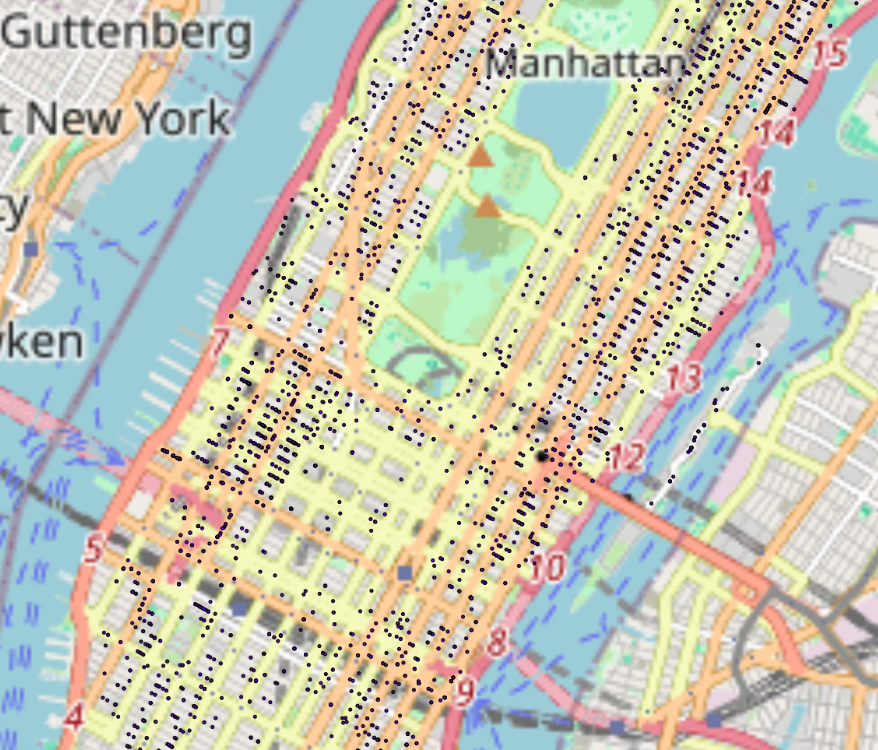

In [ ]:
from google.colab import files
from IPython.display import Image
uploaded = files.upload()
Image(filename='manhattan_map.png')

In [ ]:
geometry = [Point(xy) for xy in zip(evictions_bronx['longitude'], evictions_bronx['latitude'])]
evictions_gdf = gpd.GeoDataFrame(evictions_bronx, geometry=geometry, crs="EPSG:4326")

evictions_gdf = evictions_gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(80, 48))
evictions_gdf.plot(ax=ax, column='cluster', cmap='rainbow', legend=True, markersize=7, edgecolor='k')

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=12)

plt.title('DBSCAN clustering of Manhattan Eviction Data (longitude vs latitude)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# it's just not very clear

In [ ]:
# os.environ["SHAPE_RESTORE_SHX"] = "YES"
# buildings = gpd.read_file('building.shp')

### Use Folium

In [ ]:
# folium is more clear
# takes a while and a lot of psace to load this map
# therefore, will not rerun, but upload a screenshot,
# to see the interactive effect, needs to be rerun

nyc_cluster_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

# add cluster markers using Folium's MarkerCluster
marker_cluster = MarkerCluster().add_to(nyc_cluster_map)

# define a colormap for the clusters
# and create colormap
# map each cluster ID to a specific color
unique_clusters = set(evictions_staten_island['cluster'])
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_clusters)))
# https://matplotlib.org/1.3.0/api/colors_api.html
cluster_color_map = {}
for i, cluster_id in enumerate(unique_clusters):
    color_hex = mcolors.rgb2hex(colors[i])
    cluster_color_map[cluster_id] = color_hex

for idx, row in evictions_staten_island.iterrows():
    cluster_id = row['cluster']
    # set noise points are black if any, but we don't have them here.
    if cluster_id == -1:
        folium.Marker(location=[row['latitude'], row['longitude']],
                      popup=f"Eviction Count: {row['average_year_eviction_count']}, Noise",
                      icon=folium.Icon(color='black')).add_to(marker_cluster)
    else:
        color = cluster_color_map[cluster_id]
        folium.Marker(location=[row['latitude'], row['longitude']],
                      popup=f"Eviction Count: {row['average_year_eviction_count']}, Cluster: {cluster_id}",
                      icon=folium.Icon(color=color)).add_to(marker_cluster)

nyc_cluster_map


Saving staten_island_map.png to staten_island_map.png


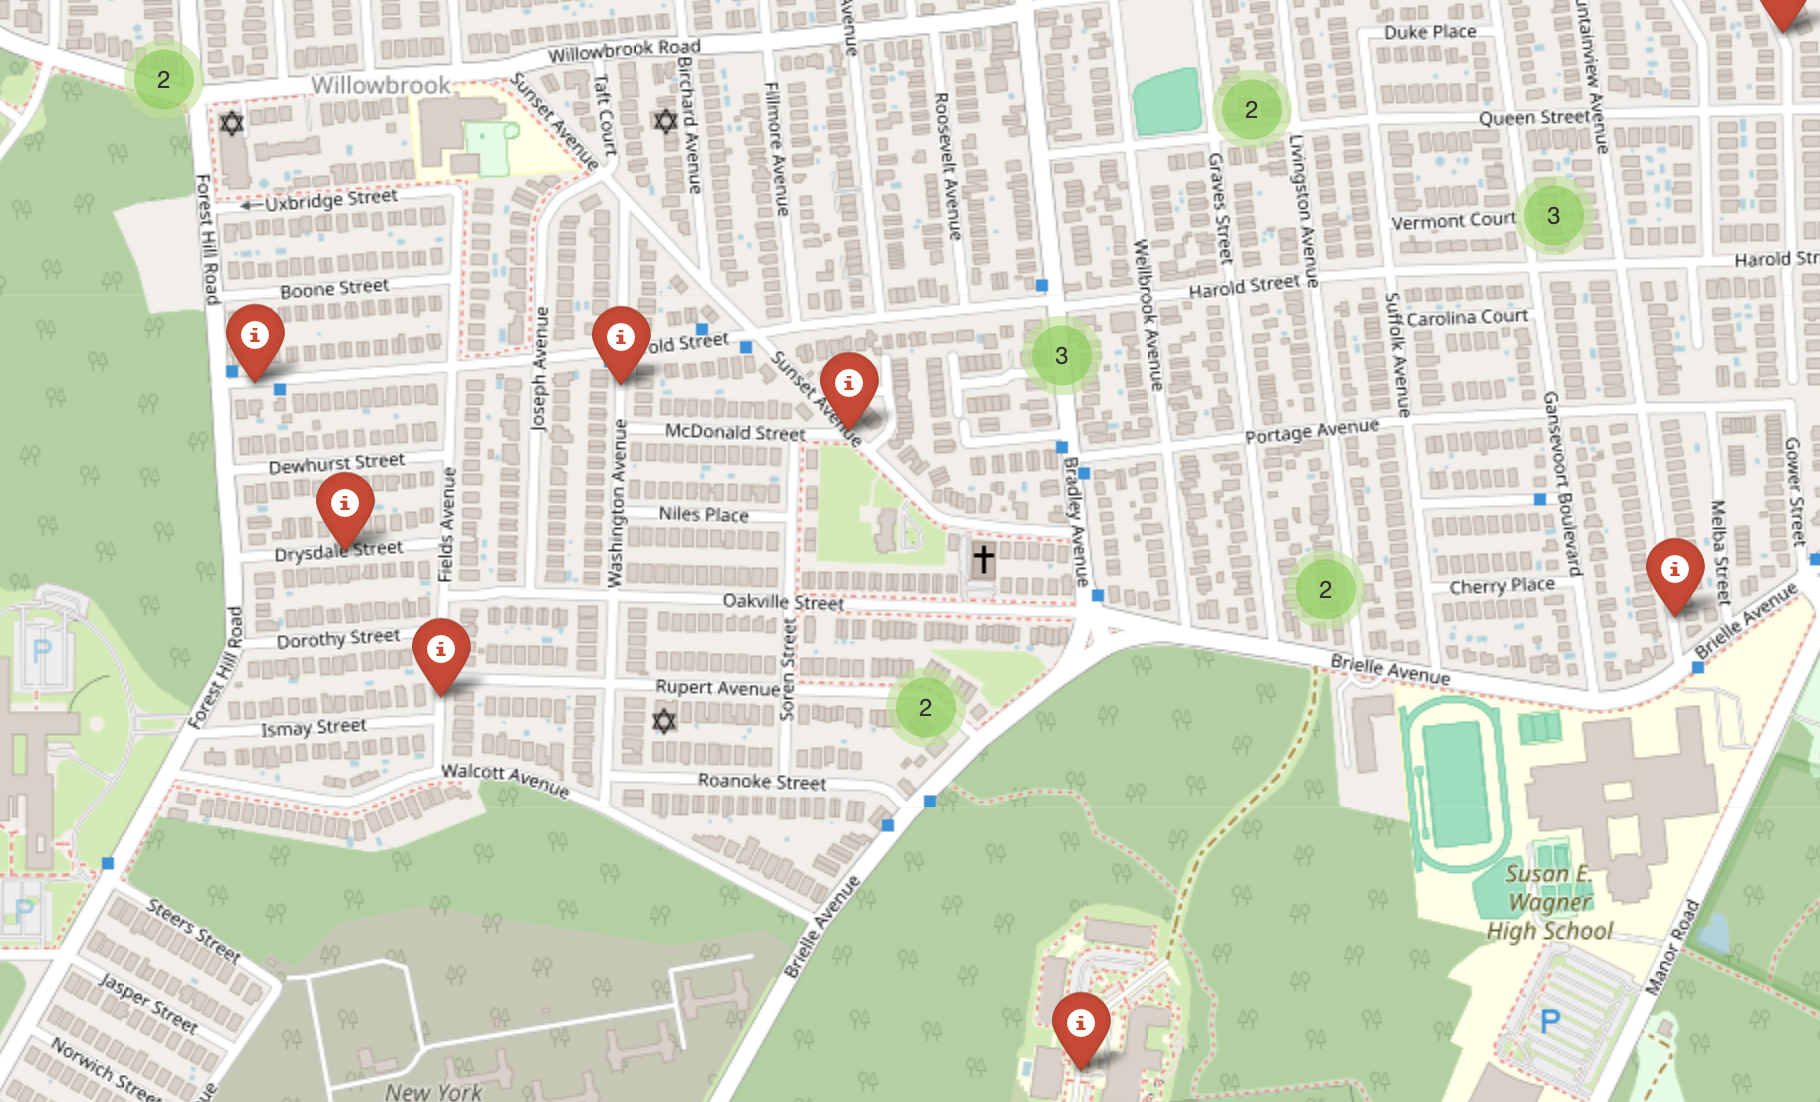

In [ ]:
from google.colab import files
from IPython.display import Image
uploaded = files.upload()
Image(filename='staten_island_map.png')

In [ ]:
# manhattan

nyc_cluster_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

# add cluster markers using Folium's MarkerCluster
marker_cluster = MarkerCluster().add_to(nyc_cluster_map)

# define a colormap for the clusters
# and create colormap
# map each cluster ID to a specific color
unique_clusters = set(evictions_manhattan['cluster'])
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_clusters)))
# https://matplotlib.org/1.3.0/api/colors_api.html
cluster_color_map = {}
for i, cluster_id in enumerate(unique_clusters):
    color_hex = mcolors.rgb2hex(colors[i])
    cluster_color_map[cluster_id] = color_hex

for idx, row in evictions_manhattan.iterrows():
    cluster_id = row['cluster']
    # set noise points are black if any, but we don't have them here.
    if cluster_id == -1:
        folium.Marker(location=[row['latitude'], row['longitude']],
                      popup=f"Eviction Count: {row['average_year_eviction_count']}, Noise",
                      icon=folium.Icon(color='black')).add_to(marker_cluster)
    else:
        color = cluster_color_map[cluster_id]
        folium.Marker(location=[row['latitude'], row['longitude']],
                      popup=f"Eviction Count: {row['average_year_eviction_count']}, Cluster: {cluster_id}",
                      icon=folium.Icon(color=color)).add_to(marker_cluster)

nyc_cluster_map


Saving manhattan_map2.png to manhattan_map2 (1).png


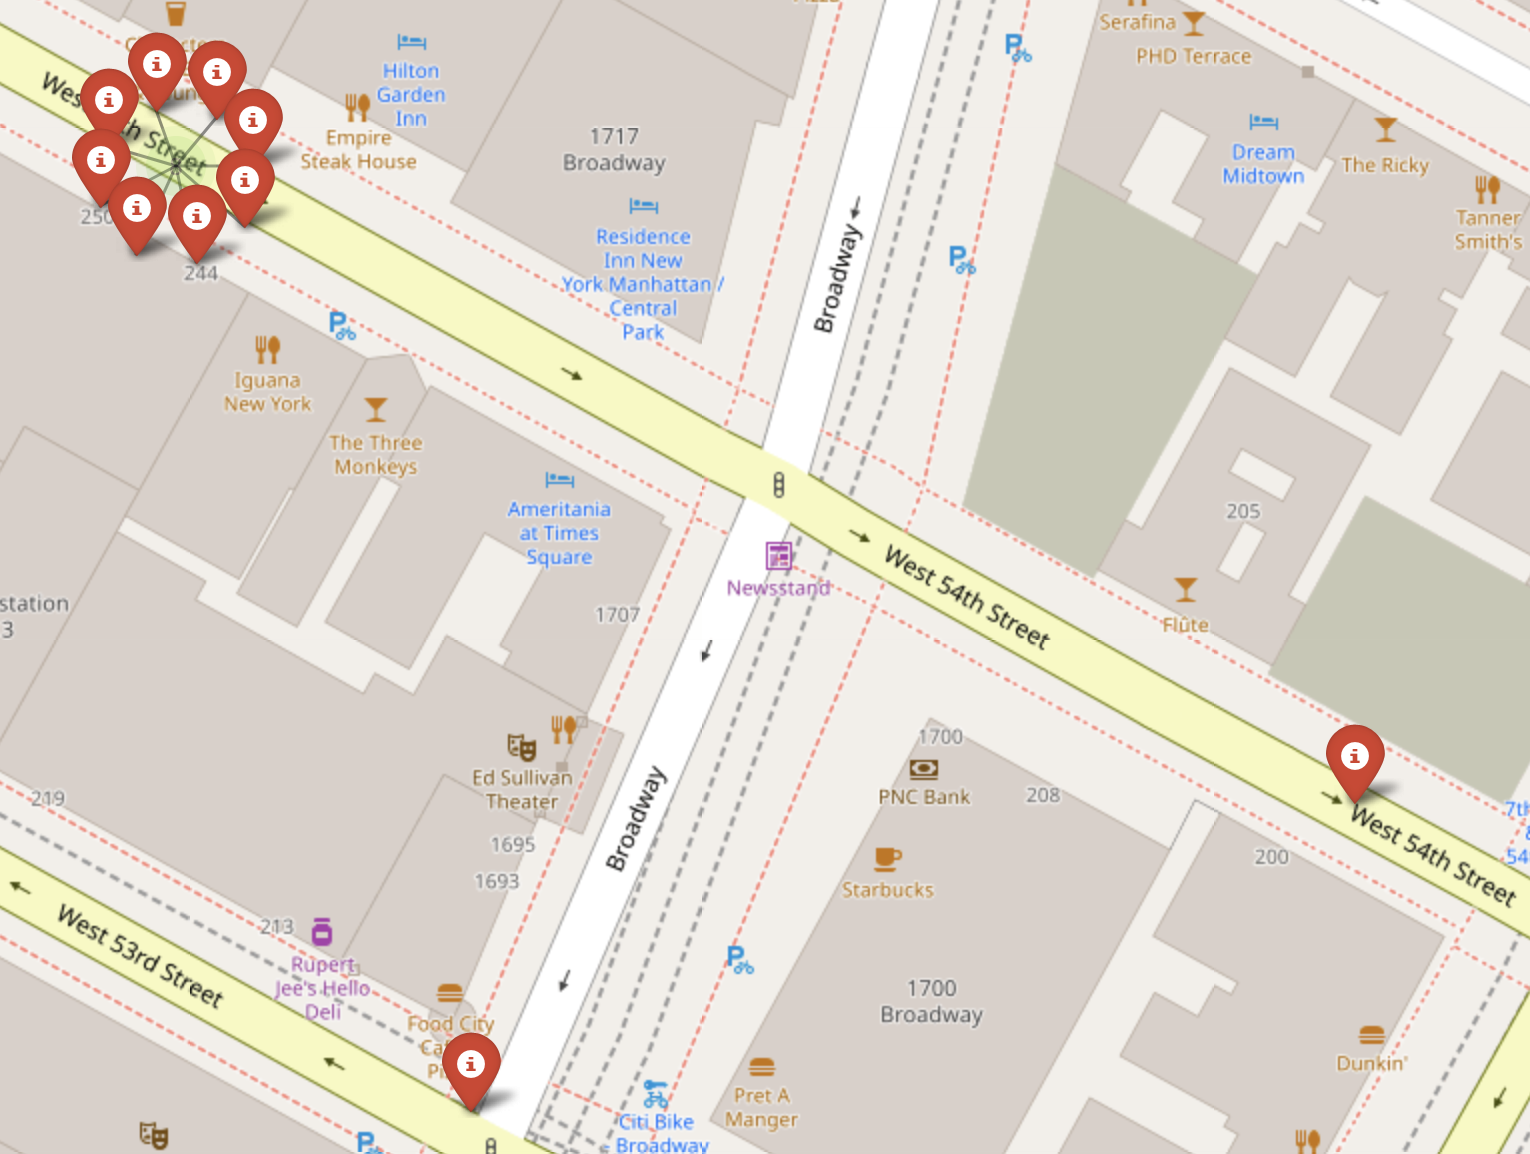

In [ ]:
from google.colab import files
from IPython.display import Image
uploaded = files.upload()
Image(filename='manhattan_map2.png')

In [ ]:
# # save the map as an HTML file because it is interactive and can be used later
# nyc_cluster_map.save('eviction_clusters_map.html')

Saving nyc_cluster_map.png to nyc_cluster_map.png


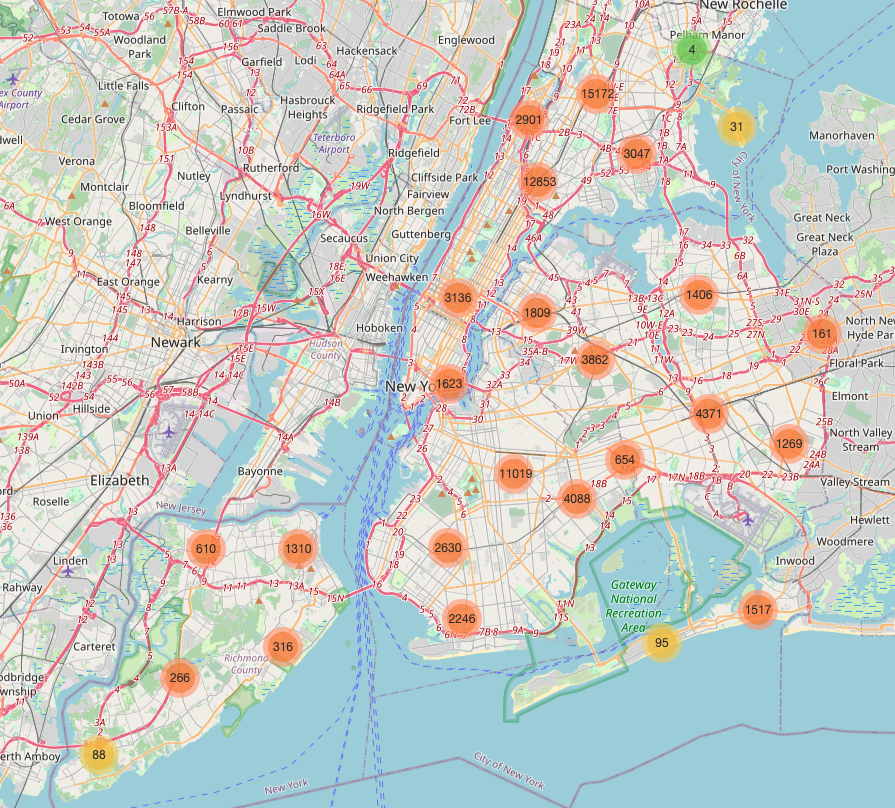

In [ ]:
from google.colab import files
from IPython.display import Image
uploaded = files.upload()
Image(filename='nyc_cluster_map.png')

In [ ]:
evictions_cleaned.crs = "EPSG:4326"  # WGS 84, the most common CRS for latitude/longitude

### Part 3.3 K means (with k = 3 as given by DBSCAN)

- doing this more like a confirmation/robustness test.
- later analysis will only use the clusters identified by DBSCAN
- both cluster algorithms here are trying to explain "magnitude of evictions"

In [ ]:
# repeat the same procedures as DBSCAN.

eviction_counts = evictions_cleaned[['average_year_eviction_count']]
scaler = StandardScaler()
eviction_counts_scaled = scaler.fit_transform(eviction_counts)

k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
evictions_cleaned['cluster_k'] = kmeans.fit_predict(eviction_counts_scaled)
centroids = kmeans.cluster_centers_

In [ ]:
print("cluster centers: \n", centroids)
n_clusters = len(set(evictions_cleaned['cluster_k']))
print("number of clusters: ", n_clusters)

cluster centers: 
 [[-0.20685944]
 [ 7.04961931]
 [ 1.51757641]]
number of clusters:  3


In [ ]:
evictions_cleaned[['average_year_eviction_count', 'cluster_k']].head()

average_year_eviction_count  cluster_k
0                     3.000000          0
1                     3.000000          0
2                     4.000000          0
3                     2.250000          0
4                     2.666667          0

In [ ]:
# put these two graphs together in later cells
# plt.figure(figsize=(20, 12))

# sns.scatterplot(
#     x=evictions_cleaned['longitude'],
#     y=evictions_cleaned['latitude'],
#     hue=evictions_cleaned['cluster_k'],
#     palette='viridis',
#     legend='full'
# )

# plt.title('K-Means Clustering of Eviction Counts')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.legend(title='Cluster')
# plt.show()


In [ ]:
# plt.figure(figsize=(20, 12))
# sns.scatterplot(
#     x=evictions_cleaned['longitude'],
#     y=evictions_cleaned['latitude'],
#     hue=evictions_cleaned['cluster'],
#     palette='viridis',
#     legend='full'
# )

# plt.title('DBSCAN Clustering of Eviction Counts')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.legend(title='Cluster')
# plt.show()


### Part 3.3.1 Quck comparisons between DBSCAN and K means cluster classifications:

In [ ]:
evictions_cleaned['same_cluster'] = evictions_cleaned['cluster_k'] == evictions_cleaned['cluster']

same_cluster_count = evictions_cleaned['same_cluster'].sum()
total_points = len(evictions_cleaned)

print(same_cluster_count, "out of ", total_points, " points were assigned to the same cluster by both K-Means and DBSCAN.")


71351 out of  76484  points were assigned to the same cluster by both K-Means and DBSCAN.


In [ ]:
# take a long time to run
kmeans_silhouette = silhouette_score(eviction_counts_scaled, evictions_cleaned['cluster_k'])
dbscan_valid_points = evictions_cleaned[evictions_cleaned['cluster'] != -1]
dbscan_silhouette = silhouette_score(eviction_counts_scaled[dbscan_valid_points.index], dbscan_valid_points['cluster'])

print("K-Means silhouette score: ", kmeans_silhouette, "DBSCAN ss: ", dbscan_silhouette)

K-Means silhouette score:  0.813322724539871 DBSCAN ss:  0.9231796852056902


#### Short summary:

According to silhouette score, DBSCAN has a higher score (0.923) than K-Means (0.813). This indicates that DBSCAN is better at clustering evictions data based on the metrics used.

#### Underlying reasons why DBSCAN works better than K-means in this case:

What Kmeans does is to use the given cluster number k and randomly initialize k centroids and then assign each data point to its nearrest centroid. Recalculate the distance and repeat until the convergence is achieved. It is assumed that the data somehow has some underlying centroids in them. However it is probably not the case with geo data if the streets/blocks/buildings are not arranged in a way that is closer to an imagined centroid. The DBSCAN works better because it is a density-based clustering, and our assumption/hypothesis that buildings who have higher eviction rates tend to be closer to each other fits the descriptions very well. DBSCAN can also discorver clusters of arbitrary shapes, where as kmeans assumes the clusters are spherical. ALso dcscan does not require a preassumption about the number of clusters. So it can go into the data and find its centers by itself.

##### source:
https://www.geeksforgeeks.org/dbscan-clustering-in-ml-density-based-clustering/ \
https://www.newhorizons.com/resources/blog/dbscan-vs-kmeans-a-guide-in-python \
https://stanford.edu/~cpiech/cs221/handouts/kmeans.html

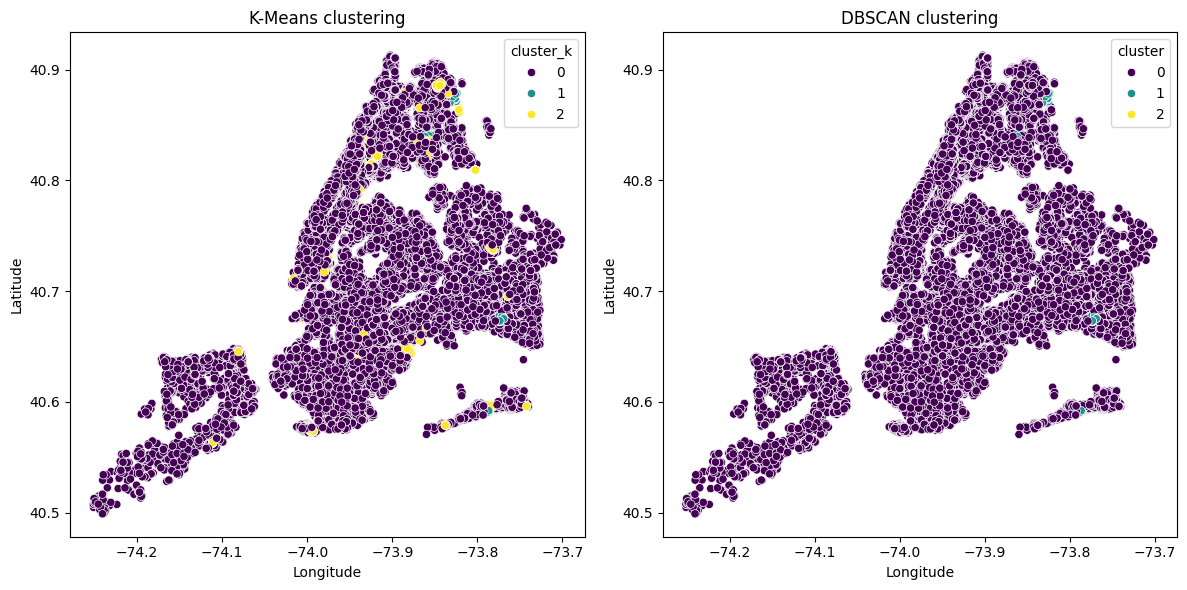

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=evictions_cleaned['longitude'],
                y=evictions_cleaned['latitude'],
                hue=evictions_cleaned['cluster_k'],
                palette='viridis',
                legend='full')
plt.title('K-Means clustering')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.subplot(1, 2, 2)
sns.scatterplot(x=evictions_cleaned['longitude'],
                y=evictions_cleaned['latitude'],
                hue=evictions_cleaned['cluster'],
                palette='viridis',
                legend='full')
plt.title('DBSCAN clustering')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.tight_layout()
plt.show()


In [ ]:
evictions_cleaned.columns,
evictions_cleaned.shape

(76484, 24)

In [ ]:
# save cleaned evictions data to my drive
evictions_cleaned.to_csv('/content/drive/My Drive/X999/evictions_cleaned.csv', index=False)

# Part 4: Analysis on the clusters (and further clusters will be included in Notebook 3)